In [1]:
from typing import List

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio

from IPython.display import Audio

#### Download dataset

In [2]:
dataset = torchaudio.datasets.YESNO(root='.', download=True)

In [3]:
len(dataset)

60

##### An example utterance

In [4]:
example_item = dataset[6]
example_item

(tensor([[ 0.0470,  0.0475,  0.0481,  ..., -0.0001, -0.0009, -0.0013]]),
 8000,
 [0, 0, 1, 0, 1, 0, 0, 0])

In [5]:
example_waveform, sample_rate, example_label = example_item

In [6]:
Audio(example_waveform, rate=sample_rate)

In [7]:
feat_extractor = torchaudio.transforms.MFCC(sample_rate=sample_rate, n_mfcc=20)
example_feature = feat_extractor(example_waveform)

example_feature.shape, example_feature

(torch.Size([1, 20, 249]),
 tensor([[[-5.1258e+02, -5.7080e+02, -5.9242e+02,  ..., -3.5589e+02,
           -3.6677e+02, -3.9206e+02],
          [ 1.1750e+02,  5.2295e+01,  2.2675e+01,  ...,  7.2943e+01,
            5.7754e+01,  5.0482e+01],
          [ 7.6018e+01,  4.8845e+01,  2.1947e+01,  ...,  1.5192e+01,
            1.1372e+01,  1.4013e+01],
          ...,
          [ 6.3933e+00,  1.6907e-01,  8.6371e+00,  ...,  2.6550e+00,
           -2.5235e+00,  8.4847e+00],
          [ 5.3331e+00, -1.8376e+00,  7.2463e+00,  ...,  7.8460e+00,
           -7.0105e-02,  2.1713e+00],
          [ 4.7425e+00, -2.6468e+00,  6.2370e+00,  ..., -1.0944e+01,
           -1.4075e+01, -1.9117e+01]]]))

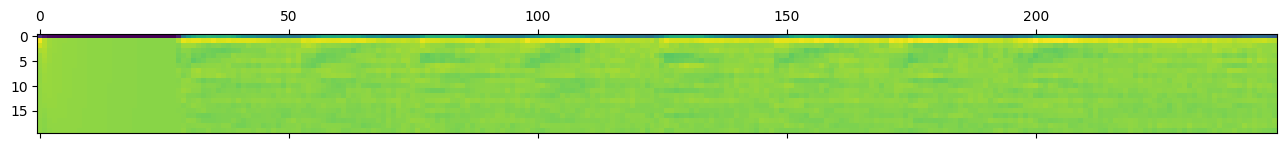

In [8]:
example_feature = example_feature.squeeze(0)
plt.matshow(example_feature)

### `YesnoMfccDataset`: Dataset with MFCC extraction

In [9]:
index_to_char = [c for c in 'eYESNO ']
char_to_index = {c: i for i, c in enumerate(index_to_char)}

In [10]:
class YesnoMfccDataset(torchaudio.datasets.YESNO):
    def __init__(self, feat_dim, **kwargs):
        super().__init__(**kwargs)
        _, sr, _ = super().__getitem__(0)
        self.feat_extractor = torchaudio.transforms.MFCC(sample_rate=sr, n_mfcc=feat_dim)

    def _labels_ints_to_text(self, labels: List[int]) -> str:
        text_of_label_int = {0: 'NO', 1: 'YES'}
        return ' '.join([text_of_label_int[label] for label in labels])

    def __getitem__(self, index):
        waveform, _, labels = super().__getitem__(index)
        feature = self.feat_extractor(waveform).squeeze(0)
        text = self._labels_ints_to_text(labels)
        labels = torch.IntTensor([char_to_index[c] for c in text])
        return feature, labels, text

In [11]:
feat_dim = 20
dataset = YesnoMfccDataset(root='.', download=True, feat_dim=feat_dim)

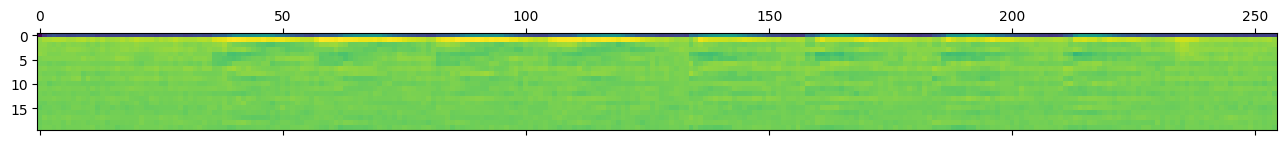

In [12]:
feature, labels, text = dataset[0]
plt.matshow(feature)

In [13]:
text, labels, dict(enumerate(index_to_char))

('NO NO NO NO YES YES YES YES',
 tensor([4, 5, 6, 4, 5, 6, 4, 5, 6, 4, 5, 6, 1, 2, 3, 6, 1, 2, 3, 6, 1, 2, 3, 6,
         1, 2, 3], dtype=torch.int32),
 {0: 'e', 1: 'Y', 2: 'E', 3: 'S', 4: 'N', 5: 'O', 6: ' '})

### Define the model

In [14]:
class YesnoNet(nn.Module):
    def __init__(self, feat_dim, hidden_size=128):
        super(YesnoNet, self).__init__()
        output_dim = len(index_to_char)
        self.lstm = nn.LSTM(feat_dim, hidden_size, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, output_dim)

    def forward(self, x):
        x = torch.transpose(x, 1, 2)
        output, _ = self.lstm(x)
        output = self.fc(output)
        output = torch.transpose(output, 0, 1)  # 'N T C -> T N C'
        return output.log_softmax(2)

In [25]:
from torchvision import models

### Let's start training!

In [15]:
torch.manual_seed(1)
train_set, test_set = torch.utils.data.random_split(dataset, [50, 10])

In [16]:
model = YesnoNet(feat_dim=feat_dim)
optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1)
ctc_loss = nn.CTCLoss()
total_epochs = 20
model_path = 'model.pt'

In [17]:
model.train()

YesnoNet(
  (lstm): LSTM(20, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=7, bias=True)
)

In [18]:
for epoch in range(total_epochs):
    for feat, label, _ in train_set:
        label, feat = torch.unsqueeze(label, 0), torch.unsqueeze(feat, 0)
        optimizer.zero_grad()
        output = model(feat)
        loss = ctc_loss(output, label, torch.IntTensor([output.shape[0]]), torch.IntTensor([label.shape[1]]))
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch}\tLoss: {loss.item()}')
    torch.save(model.state_dict(), model_path)

Epoch 0	Loss: 1.8397321701049805
Epoch 1	Loss: 1.7737153768539429
Epoch 2	Loss: 1.5327917337417603
Epoch 3	Loss: 1.1583954095840454
Epoch 4	Loss: 0.7516840696334839
Epoch 5	Loss: 0.40194040536880493
Epoch 6	Loss: 0.2514305114746094
Epoch 7	Loss: 0.18757635354995728
Epoch 8	Loss: 0.12486808747053146
Epoch 9	Loss: 0.09811263531446457
Epoch 10	Loss: 0.07182665914297104
Epoch 11	Loss: 0.049070004373788834
Epoch 12	Loss: 0.03715882822871208
Epoch 13	Loss: 0.028230972588062286
Epoch 14	Loss: 0.024645674973726273
Epoch 15	Loss: 0.017967943102121353
Epoch 16	Loss: 0.015160764567553997
Epoch 17	Loss: 0.013250105082988739
Epoch 18	Loss: 0.013681597076356411
Epoch 19	Loss: 0.01014114823192358


### Test

In [19]:
model.eval()

YesnoNet(
  (lstm): LSTM(20, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=7, bias=True)
)

In [26]:
feat, _, text = test_set[6]

In [27]:
logits = model(torch.unsqueeze(feat, 0))
logits = torch.squeeze(logits, 1)
logits.shape

torch.Size([249, 7])

In [ ]:
align = [int(torch.argmax(logit, dim=0).item()) for logit in logits]
align

In [29]:
chars = [index_to_char[c] for c in align if c != 0]
chars = [chars[i] for i in range(len(chars)) if i == 0 or chars[i] != chars[i - 1]]
result = ''.join(chars)
result

'YES YES NO YES YES YES YES NO'

In [30]:
text

'YES YES NO YES YES YES YES NO'